In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from matplotlib.colors import ListedColormap

In [3]:
IN_DIRECTORY = 'data/final/'
OUT_DIRECTORY = 'data/predictions/'

In [4]:
# columns containing data to be used as features in our model
DATA_COLUMNS = [
    'PTS', # Total Points
    'REB', # Total Rebounds
    'AST', # Total Assists
    'STL', # Total Steals
    'BLK', # Total Blocks
    'OFF_RATING', # Offensive Rating
    'DEF_RATING', # Defensive Rating
    'TS_PCT', # True Shooting percentage
    'USG_PCT', # Usage percentage
    'PIE', # Player Impact Estimate
    'WS', # Win Shares
    'PER' # Player Efficiency Rating
]

In [5]:
# get training data
train = pd.read_csv(IN_DIRECTORY + 'player_stats_training.csv')

train

,SEASON,PLAYER_NAME,TEAM_ABBREVIATION,PLAYER_ID,TEAM_ID,GP,MIN,PTS,REB,AST,...,BLK,OFF_RATING,DEF_RATING,TS_PCT,USG_PCT,PIE,WS,PER,ALL_NBA,ALL_NBA_TM
0,1996-97,A.C. Green,DAL,920,1610612742,83,2494.30,597,656,69,...,16,97.4,104.8,0.523,0.118,0.098,-0.10,13.67,0,0
1,1996-97,Aaron McKie,DET,243,1610612765,83,1623.91,433,221,161,...,22,101.5,97.8,0.524,0.142,0.095,4.05,14.96,0,0
2,1996-97,Aaron Williams,VAN,1425,1610612763,33,562.42,203,143,15,...,29,93.3,102.6,0.599,0.161,0.112,1.35,15.13,0,0
3,1996-97,Acie Earl,MIL,768,1610612749,47,500.14,188,96,20,...,28,93.6,100.0,0.435,0.220,0.056,0.13,14.24,0,0
4,1996-97,Adam Keefe,UTA,228,1610612762,62,916.79,235,216,32,...,13,106.6,99.4,0.572,0.124,0.083,3.19,12.44,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10927,2021-22,Yuta Watanabe,TOR,1629139,1610612761,38,445.46,163,92,21,...,16,105.7,109.6,0.524,0.161,0.075,-0.13,14.67,0,0
10928,2021-22,Zach Collins,SAS,1628380,1610612759,28,502.04,218,153,61,...,23,110.9,107.8,0.594,0.184,0.107,2.04,16.70,0,0
10929,2021-22,Zach LaVine,CHI,203897,1610612741,67,2328.08,1635,308,303,...,23,112.5,113.4,0.605,0.284,0.129,-1.43,23.21,0,0
10930,2021-22,Zeke Nnaji,DEN,1630192,1610612743,41,697.61,270,147,17,...,13,107.2,110.4,0.629,0.146,0.078,1.44,13.52,0,0


In [6]:
# use Random Forest Classifier
np.random.seed(6)
X = train[DATA_COLUMNS]
y = train['ALL_NBA']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=1)

rfModel = RandomForestClassifier(n_estimators=200, min_samples_leaf=5)
rfModel.fit(X_train, y_train)

print('Score:', rfModel.score(X_valid, y_valid))


Score: 0.9824368825466521


In [7]:
# get data for the 2022_23 to make predictions on
playerStats2022_23 = pd.read_csv(IN_DIRECTORY + 'player_stats_2022-23.csv')

allNBAwinners = playerStats2022_23['ALL_NBA']

In [8]:
# make predictions
allNBApredictions2022_23 = rfModel.predict(playerStats2022_23[DATA_COLUMNS])

print('Accuracy score:', accuracy_score(allNBAwinners, allNBApredictions2022_23))

Accuracy score: 0.9871794871794872


In [9]:
# add our new all-nba predictions to 2022-23 season player stats
playerStats2022_23['ALL_NBA_PRED'] = pd.DataFrame(allNBApredictions2022_23)

# get only players that either were all-nba or were predicted to be all-nba
allNBAplayersAndPredictions = playerStats2022_23[(playerStats2022_23['ALL_NBA'] == 1) | ( playerStats2022_23['ALL_NBA_PRED'] == 1)]

# add column that shows wether or not the prediction was correct
allNBAplayersAndPredictions['CORRECT'] = allNBAplayersAndPredictions.apply(lambda x : 'YES' if x['ALL_NBA'] == x['ALL_NBA_PRED'] else 'NO', axis=1)
playerStats2022_23['CORRECT'] = playerStats2022_23.apply(lambda x : 'YES' if x['ALL_NBA'] == x['ALL_NBA_PRED'] else 'NO', axis=1)

# sort by correct predictions
allNBAplayersAndPredictions = allNBAplayersAndPredictions.sort_values(by='CORRECT')

C:\Users\mikae\AppData\Local\Temp\ipykernel_16044\168829219.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allNBAplayersAndPredictions['CORRECT'] = allNBAplayersAndPredictions.apply(lambda x : 'YES' if x['ALL_NBA'] == x['ALL_NBA_PRED'] else 'NO', axis=1)


In [10]:
# save results
allNBAplayersAndPredictions = allNBAplayersAndPredictions[
    ['CORRECT', 'PLAYER_NAME', 'ALL_NBA', 'ALL_NBA_PRED']] 
    #  'PTS','REB','AST', 'STL','BLK','OFF_RATING','DEF_RATING','TS_PCT','USG_PCT','PIE', 'WS', 'PER']]
    
allNBAplayersAndPredictions.to_csv(OUT_DIRECTORY + 'allNBA_predictions_2022-23.csv', index=False)

In [11]:
# show results
correctCount = allNBAplayersAndPredictions[allNBAplayersAndPredictions['CORRECT'] == 'YES'].shape[0]
predictionsMade = allNBAplayersAndPredictions[allNBAplayersAndPredictions['ALL_NBA_PRED'] == 1].shape[0]

print('Predictions made: {}, Correct predictions: {}'.format(predictionsMade, correctCount))
print('Prediction accuracy: {}/{} = {:.3f}'.format(correctCount, predictionsMade, (correctCount / predictionsMade)))
print('True accuracy: {}/{} = {:.3f}'.format(correctCount, 15, (correctCount / 15)))
allNBAplayersAndPredictions

Predictions made: 15, Correct predictions: 12
Prediction accuracy: 12/15 = 0.800
True accuracy: 12/15 = 0.800


,CORRECT,PLAYER_NAME,ALL_NBA,ALL_NBA_PRED
20,NO,Anthony Davis,0,1
246,NO,Julius Randle,1,0
205,NO,Jaylen Brown,1,0
171,NO,Ja Morant,0,1
433,NO,Trae Young,0,1
96,NO,De'Aaron Fox,1,0
148,YES,Giannis Antetokounmpo,1,1
117,YES,Domantas Sabonis,1,1
411,YES,Stephen Curry,1,1
216,YES,Jimmy Butler,1,1


Every season, exactly 15 players are selected to All-NBA teams. Unfortunately, our model doesnt not always choose 15 All-NBA players and we cannot force our model to choose exactly 15 players as All-NBA players. This is why I calculated two accuracy scores for cases where our model selects more or less than 15 players as All-NBA.

Luckily, the current random seed did in fact lead to our model predicting 15 All-NBA players. Our model correctly predicted 12 out of 15 All-NBA players resulting in an accuracy of 80%.

In [12]:
# PCA analysis
pca = PCA(2)
X = playerStats2022_23[DATA_COLUMNS]
X2 = pca.fit_transform(StandardScaler().fit_transform(X))

In [13]:
# print variance ratio
print(pca.explained_variance_ratio_)
# print principle components
print(pca.components_)
# print features
print(DATA_COLUMNS)

[0.47509078 0.15548652]
[[ 0.37769649  0.3297008   0.31806004  0.29778405  0.22758589  0.28236054
   0.04151527  0.20480592  0.28673724  0.36377371  0.19631375  0.36128212]
 [ 0.18754015 -0.17173777  0.22163299  0.09507413 -0.33855029 -0.10088183
   0.45395661 -0.3338517   0.36579772 -0.04527677 -0.52396523  0.15636506]]
['PTS', 'REB', 'AST', 'STL', 'BLK', 'OFF_RATING', 'DEF_RATING', 'TS_PCT', 'USG_PCT', 'PIE', 'WS', 'PER']


From the variance ratio is seems that the first principle component is much more important than the second principle componenet.

#### First principle component
Top 5 features in order of decreasing variance:
1. `Points`
2. `Player Impact Estimate`
3. `Player Efficiency Rating`
4. `Rebounds`
5. `Assists`

All of the features seem to be fairly weighted with `Points` having the highest variance. The only exception was `Defensive Rating` which had a much lower variance compared to the others.

#### Second principle component
Top 5 features in order of decreasing variance:
1. `Defensive Rating`
2. `Usage Percentage`
3. `Assists`
4. `Points`
5. `Player Efficiency Rating`

The second principle component valued `Defensive Rating` the most, which could explain the exception in the first component. `Usage Percentage` also had a much higher variance than the rest of the features.

Both principle components had higher variances for `Points`, `Assists`, and `Player Efficiency Rating` which indicates that these are the most important stats for selecting All-NBA players.

In [14]:
sns.set_theme()

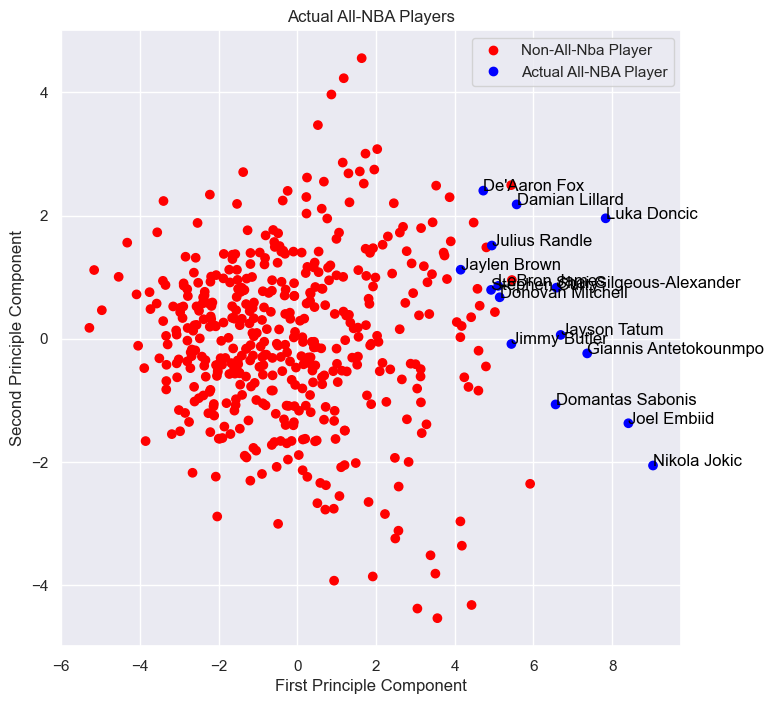

In [15]:
plt.figure(figsize=(8,8))
colors = ListedColormap(['red','blue'])
scatter = plt.scatter(X2[:, 0], X2[:, 1], c=playerStats2022_23['ALL_NBA'], cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=['Non-All-Nba Player', 'Actual All-NBA Player'])
for i, (x, y) in enumerate(zip(X2[:, 0], X2[:, 1])):
    if playerStats2022_23['ALL_NBA'][i] == 1:
        plt.text(x, y, playerStats2022_23['PLAYER_NAME'][i], color='black')
plt.title('Actual All-NBA Players')
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')
plt.show()

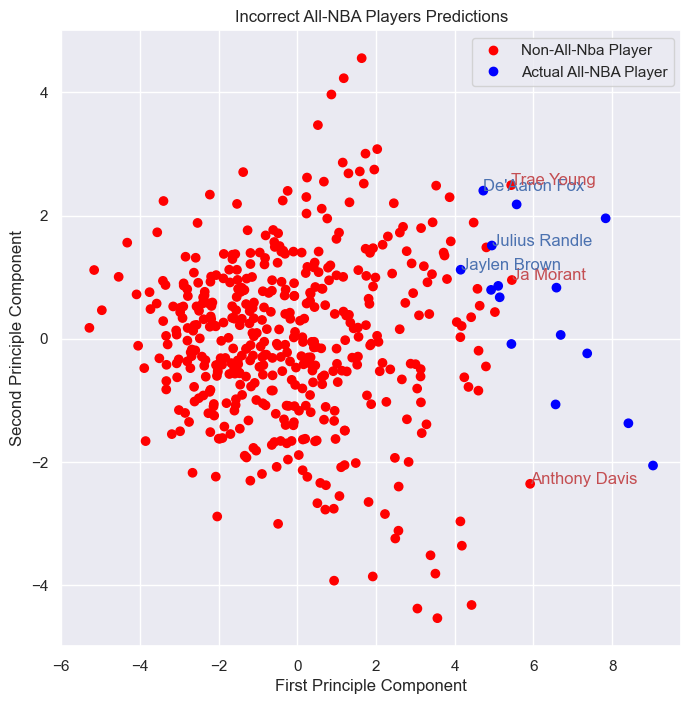

In [18]:
# incorrect predictions
# model believed players with red names deserved to be All-NBA when they are not
# model believed players with blue names were not All-NBA but they actually are
plt.figure(figsize=(8,8))

scatter = plt.scatter(X2[:, 0], X2[:, 1], c=playerStats2022_23['ALL_NBA'], cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=['Non-All-Nba Player', 'Actual All-NBA Player'])
for i, (x, y) in enumerate(zip(X2[:, 0], X2[:, 1])):
    if (playerStats2022_23['ALL_NBA_PRED'][i] != playerStats2022_23['ALL_NBA'][i]) and playerStats2022_23['ALL_NBA'][i] == 0:
        plt.text(x, y, playerStats2022_23['PLAYER_NAME'][i], color='r')
    if (playerStats2022_23['ALL_NBA_PRED'][i] != playerStats2022_23['ALL_NBA'][i]) and playerStats2022_23['ALL_NBA'][i] == 1:
        plt.text(x, y, playerStats2022_23['PLAYER_NAME'][i], color='b')
plt.title('Incorrect All-NBA Players Predictions')
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')
plt.show()

Our model incorrectly predicted that 'Trae Young', 'Ja Morant', and 'Anthony Davis' were All-NBA level players. This is quite interesting as these three players were widely considered as the biggest All-NBA team snubs, indicating that our model may be more accurate than it seems at first glance.

From this graph we can see that these players were clearly weighted more positively on the x-axis compared to the other 3 actual All-NBA players ('De'Aaron Fox', 'Julius Randle', and 'Jaylen Brown'). The reason that these players weren't actually selected as All-NBA players is likely be due to various influences that our model didn't account for. 

One of these being that, in reality, players aren't selected by an algorithm or purely based off of statistics. Instead, a group of 100 sportswriters and broadcasters get to vote for players they personally believe deserve the award (https://www.sportskeeda.com/basketball/news-how-all-nba-teams-selected-selection-process-details-explored). These voters may use information that our model isn't aware of to inform their decisions. For example, our model doesn't particularly value the perfomance of a player's team. In addition, our model doesn't know about games played. Games played is largely considered the reason why `Anthony Davis` was snubbed as he only played in 56 games compared to actual All-NBA forward `Julius Randle`'s 77 games palyed (who our model did not believe to be All-NBA level).

Another notable difference between these six players is that the three players that our model selected all had higher `Player Efficiency Rating` and `Win Shares` than the 3 actual All-NBA players. This makes sense as our principle component analysis revealed that `Player Efficiency Rating` was particularly important to our model.

Overall, our model's mistakes seem to be somewhat reasonable and in the eyes of many NBA fans, our model may even be more accurate than the accuracy score would suggest.

In [29]:
temp = pd.DataFrame()
temp = pd.concat([temp, playerStats2022_23[playerStats2022_23['PLAYER_NAME'] == 'Trae Young']])
temp = pd.concat([temp, playerStats2022_23[playerStats2022_23['PLAYER_NAME'] == 'Ja Morant']])
temp = pd.concat([temp, playerStats2022_23[playerStats2022_23['PLAYER_NAME'] == 'Anthony Davis']])
temp = pd.concat([temp, playerStats2022_23[playerStats2022_23['PLAYER_NAME'] == 'De\'Aaron Fox']])
temp = pd.concat([temp, playerStats2022_23[playerStats2022_23['PLAYER_NAME'] == 'Julius Randle']])
temp = pd.concat([temp, playerStats2022_23[playerStats2022_23['PLAYER_NAME'] == 'Jaylen Brown']])
temp

,SEASON,PLAYER_NAME,TEAM_ABBREVIATION,PLAYER_ID,TEAM_ID,GP,MIN,PTS,REB,AST,...,DEF_RATING,TS_PCT,USG_PCT,PIE,WS,PER,ALL_NBA,ALL_NBA_TM,ALL_NBA_PRED,CORRECT
433,2022-23,Trae Young,ATL,1629027,1610612737,73,2540.74,1914,217,741,...,114.6,0.573,0.313,0.143,6.38,24.14,0,0,1,NO
171,2022-23,Ja Morant,MEM,1629630,1610612763,61,1948.35,1596,357,493,...,108.5,0.557,0.338,0.175,8.71,26.48,0,0,1,NO
20,2022-23,Anthony Davis,LAL,203076,1610612747,56,1904.51,1451,702,148,...,109.5,0.627,0.277,0.186,11.68,25.57,0,0,1,NO
96,2022-23,De'Aaron Fox,SAC,1628368,1610612758,73,2435.24,1826,306,447,...,116.8,0.599,0.288,0.137,0.20,23.51,1,3rd,0,NO
246,2022-23,Julius Randle,NYK,203944,1610612752,77,2737.25,1936,767,316,...,115.4,0.581,0.288,0.148,1.08,23.36,1,3rd,0,NO
205,2022-23,Jaylen Brown,BOS,1627759,1610612738,67,2404.92,1784,459,232,...,111.2,0.581,0.307,0.132,2.34,22.46,1,2nd,0,NO


In [17]:
# finally, I wanted to make predictions on the current season (2023-24) just for fun!
# we won't be able to test the accuracy of these predictions as the All-NBA teams for this season haven't been selected yet!

# get data
playerStats2023_24 = pd.read_csv(IN_DIRECTORY + 'player_stats_2023-24.csv')

# make prediction
allNBApredictions2023_24 = rfModel.predict(playerStats2023_24[DATA_COLUMNS])

# add predictions to data
playerStats2023_24['ALL_NBA_PRED'] = pd.DataFrame(allNBApredictions2023_24)

# get only players that were predicted to be all-nba
playerStats2023_24 = playerStats2023_24[playerStats2023_24['ALL_NBA_PRED'] == 1]

# save results
playerStats2023_24 = playerStats2023_24[['PLAYER_NAME', 'ALL_NBA_PRED']] 

playerStats2023_24.to_csv(OUT_DIRECTORY + 'allNBA_predictions_2023-24.csv', index=False)